# Part II: Explanatory Analysis
This notebook presents the key insights and polished visualizations from the exploratory analysis, focusing on the core narrative: **The GoBike System's dual-purpose usage.**

## Investigation Overview
The primary goal was to understand the different use cases of the Ford GoBike system by examining the two user segments: **Subscribers (commuters)** and **Customers (casual riders).** The analysis confirms a strong split in behavior and purpose, crucial for system planning and marketing.

### 1. Key Insight 1: The Commuter Reliance
**Finding:** The system is fundamentally a **commuter service**, overwhelmingly dominated by subscribers during peak weekday hours.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set a consistent style for professional plots
sns.set_style('darkgrid')
%matplotlib inline

# load the dataset
df = pd.read_csv('201902-fordgobike-tripdata.csv')
df_original = df.copy()

def wrangle_gobike_data(df):
    """ Cleans data and engineers time, duration, and age features. """
    # 1. convert time and calculate derived features
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    df['start_hour'] = df['start_time'].dt.hour
    df['start_day'] = df['start_time'].dt.day_name()

    # order days correctly
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['start_day'] = pd.Categorical(df['start_day'], categories=day_order, ordered=True)

    # duration in minutes
    df['duration_min'] = df['duration_sec'] / 60

    # 2. member age (data is from 2019)
    CURRENT_YEAR = 2019 
    df['member_age'] = CURRENT_YEAR - df['member_birth_year'].fillna(0).astype(int)

    # 3. filtering and type conversion
    #  filter out extreme outliers (e.g., age > 80 or < 18)
    df = df.query('member_age >= 18 and member_age <= 80')
    df.dropna(subset=['member_gender'], inplace=True) # Drop missing gender for demographics

    for col in ['user_type', 'member_gender']:
        df[col] = df[col].astype('category')

    print(f'data cleaned. final shape: {df.shape}')
    return df

df = wrangle_gobike_data(df)

data cleaned. final shape: (174955, 20)


C:\Users\Darawsheh\AppData\Local\Temp\ipykernel_2380\846345066.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['member_gender'], inplace=True) # Drop missing gender for demographics
C:\Users\Darawsheh\AppData\Local\Temp\ipykernel_2380\846345066.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
C:\Users\Darawsheh\AppData\Local\Temp\ipykernel_2380\846345066.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

C:\Users\Darawsheh\AppData\Local\Temp\ipykernel_2380\2400723107.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  usage_by_hour = df.groupby(['start_hour', 'user_type']).size().reset_index(name='count')


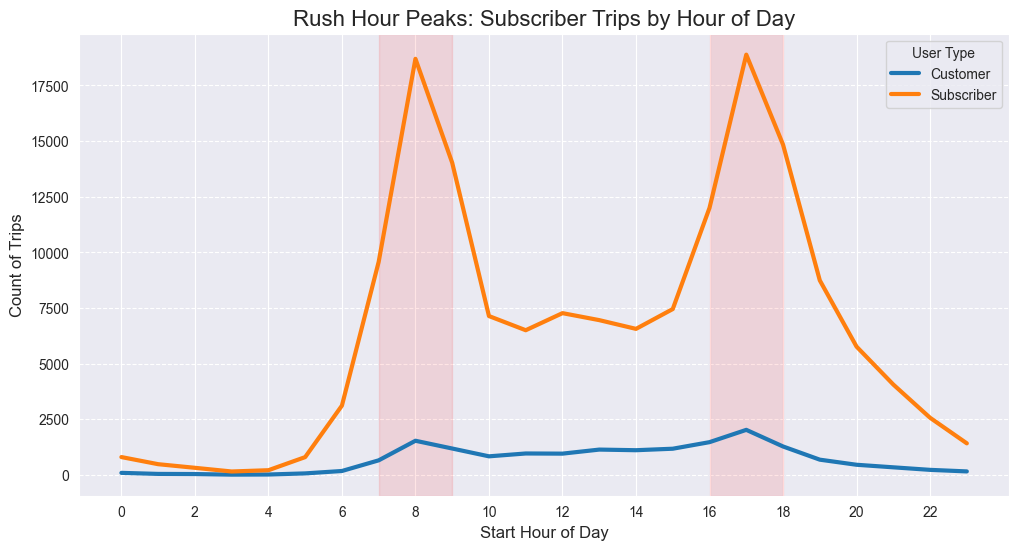

In [9]:
# POLISHED VISUALIZATION 1: Daily and Hourly Usage
plt.figure(figsize=(12, 6))

# Aggregate data by hour and user type
usage_by_hour = df.groupby(['start_hour', 'user_type']).size().reset_index(name='count')

sns.lineplot(data=usage_by_hour, x='start_hour', y='count', hue='user_type', 
             linewidth=3, palette=['#1f77b4', '#ff7f0e']) # Clear colors

plt.title('Rush Hour Peaks: Subscriber Trips by Hour of Day', fontsize=16)
plt.xlabel('Start Hour of Day', fontsize=12)
plt.ylabel('Count of Trips', fontsize=12)
plt.xticks(np.arange(0, 24, 2))
plt.legend(title='User Type', fontsize=10)

# Annotation for rush hour
plt.axvspan(7, 9, color='red', alpha=0.1, label='AM Peak')
plt.axvspan(16, 18, color='red', alpha=0.1, label='PM Peak')

plt.grid(axis='y', linestyle='--')
plt.show()

### 2. Key Insight 2: The Duration Difference
**Finding: Casual Customers** take significantly longer median trips than Subscribers, suggesting recreational or sightseeing use rather than commuting.

C:\Users\Darawsheh\AppData\Local\Temp\ipykernel_2380\1745148179.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='user_type', y='duration_min', palette=['#1f77b4', '#ff7f0e'],


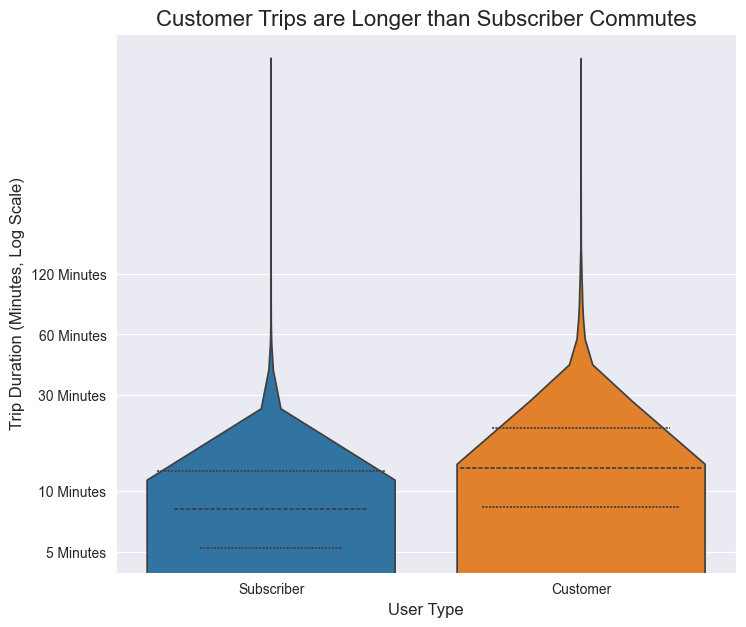

In [10]:
# POLISHED VISUALIZATION 2: Duration Comparison (Violin Plot)
plt.figure(figsize=(8, 7))

# Create violin plot with log scale for clear median comparison
sns.violinplot(data=df, x='user_type', y='duration_min', palette=['#1f77b4', '#ff7f0e'], 
               inner='quartile', order=['Subscriber', 'Customer'])

plt.yscale('log')
# Set clear, interpretable tick labels in MINUTES
tick_locs = [5, 10, 30, 60, 120]
plt.yticks(tick_locs, [f'{i} Minutes' for i in tick_locs])

plt.title('Customer Trips are Longer than Subscriber Commutes', fontsize=16)
plt.xlabel('User Type', fontsize=12)
plt.ylabel('Trip Duration (Minutes, Log Scale)', fontsize=12)
plt.show()

### 3. Key Insight 3: Weekend Usage Shifts
**Finding:** The average trip length is shortest during weekdays (due to high volume of quick commutes) and **longest on the weekends,** highlighting the shift toward leisure use.

C:\Users\Darawsheh\AppData\Local\Temp\ipykernel_2380\1362479009.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_duration_day = df.groupby('start_day')['duration_min'].mean().reset_index(name='mean_duration')


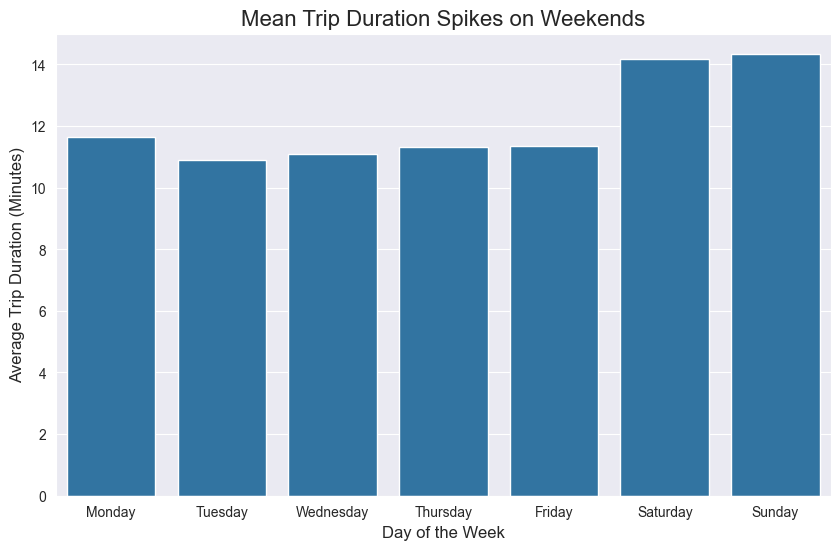

In [11]:
# POLISHED VISUALIZATION 3: Mean Duration by Day
plt.figure(figsize=(10, 6))

# Calculate mean duration for each day
mean_duration_day = df.groupby('start_day')['duration_min'].mean().reset_index(name='mean_duration')

# Plot as a bar chart
sns.barplot(data=mean_duration_day, x='start_day', y='mean_duration', color='#1f77b4')

plt.title('Mean Trip Duration Spikes on Weekends', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Trip Duration (Minutes)', fontsize=12)
plt.ylim(0, 15) # Cap the y-axis for better visual comparison
plt.show()

## Conclusion Summary
The exploratory analysis successfully identified two distinct user profiles:  
**1. The Subscriber Commuter:** High-frequency, short-duration trips clustered during weekday rush hours. This group forms the foundation of the system's usage.  
**2. The Casual Customer:** Low-frequency, long-duration trips, peaking midday and on weekends, indicating leisure use.